In [1]:
%matplotlib inline
%precision 3

import numpy as np
from numpy import nan as NA
from numpy.random import randn
from numpy import corrcoef, arange
np.random.seed(123)

import pandas as pd
import os
import datetime
import re

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from pylab import pcolor, show, colorbar, xticks, yticks
from matplotlib.ticker import PercentFormatter

plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4)
pd.options.display.max_rows = 10



In [2]:
#!powershell -command "& {gc NCDB_1999_to_2014.csv -head 10}"
#!powershell -command "& {gc NCDB_1999_to_2014_s.csv -head 10}"

In [3]:
#accident = pd.read_csv('NCDB_1999_to_2014.csv', engine = 'python')
#accident = pd.read_csv('NCDB_1999_to_2014_s.csv', engine = 'python')
#accident = pd.read_csv('../../data/small/NCDB_1999_to_2014-002.csv', engine = 'python') #-- small
accident = pd.read_csv('../../data/NCDB_1999_to_2014.csv', engine = 'python') # -- full

In [4]:
#replace all column head to lower case.

accident.columns = accident.columns.map(lambda x: x[:].lower())
accident

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
0,1999,01,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,01,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,01,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,01,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860400,2014,UU,U,UU,2,UU,UU,01,U,U,...,13,07,UUUU,01,M,24,11,1,NN,1
5860401,2014,UU,U,23,2,01,06,05,1,1,...,01,14,2006,01,M,29,96,2,09,5
5860402,2014,UU,U,14,2,01,02,01,1,5,...,01,01,2006,01,F,UU,11,2,01,1
5860403,2014,UU,U,22,1,01,06,01,2,4,...,01,22,UUUU,01,M,67,12,3,01,U


##### Collision level data elements

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|C_YEAR|1 – 4|4|Year|
|C_MNTH|5 – 6|2|Month|
|C_WDAY|7|1|Day of week|
|C_HOUR|8 – 9|2|Collision hour|
|C_SEV|10|1|Collision severity|
|C_VEHS|11 – 12|2|Number of vehicles involved in collision|
|C_CONF|13 – 14|2|Collision configuration|
|C_RCFG|15 – 16|2|Roadway configuration|
|C_WTHR|17|1|Weather condition|
|C_RSUR|18|1|Road surface|
|C_RALN|19|1|Road alignment|
|C_TRAF|20 – 21|2|Traffic control|

##### Vehicle level data elements

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|V_ID|22 – 23|2|Vehicle sequence number|
|V_TYPE|24 – 25|2|Vehicle type|
|V_YEAR|26 – 29|4|Vehicle model year|



##### Person level data elements

|Data element|Columns|Column size|Definition|
|--|--|--|--|
|P_ID|30 – 31|2|Person sequence number|
|P_SEX|32|1|Person sex|
|P_AGE|33 – 34|2|Person age|
|P_PSN|35 – 36|2|Person position|
|P_ISEV|37|1|Medical treatment required|
|P_SAFE|38 – 39|2|Safety device used|
|P_USER|40|1|Road user class|


#### Data cleaning and normalization

In [5]:
#remove all special values (unknown to us) in date-time columns, prepare for using date series as index.
#make a copy "df" for further analysis, avoid mess up the original data "accident".

df = accident[:]
df[['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf']]=df[['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf']].replace('[^0-9]+',np.nan,regex=True)

df.dropna(axis=0,subset=['c_mnth','c_wday','c_hour','c_rcfg','c_wthr','c_rsur','c_traf'],inplace=True)
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
46,1999,01,1,15,2,01,QQ,01,1,1,...,01,01,1995,01,M,17,11,1,02,1
47,1999,01,1,15,2,01,QQ,01,1,1,...,99,NN,NNNN,02,F,41,99,2,NN,3
52,1999,01,1,09,2,02,34,02,1,1,...,01,01,1992,01,F,33,11,2,02,1
53,1999,01,1,09,2,02,34,02,1,1,...,01,01,1992,02,F,UU,23,1,02,2
54,1999,01,1,09,2,02,34,02,1,1,...,02,01,1992,01,F,70,11,1,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860376,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,01,M,44,11,1,02,1
5860377,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,02,M,34,13,2,02,2
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,02,M,26,13,1,02,2


In [6]:
#generate the date-time column "date", and assign it as the index.

#df['date'] = pd.DatetimeIndex(df['c_year'].map(str) + '-' + df['c_mnth'] + '-' + df['c_wday'] + ' ' + df['c_hour'] + ':0:0')
df['date'] = pd.PeriodIndex(df['c_year'].map(str) + '-' + df['c_mnth'], freq='M')
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user,date
46,1999,01,1,15,2,01,QQ,01,1,1,...,01,1995,01,M,17,11,1,02,1,1999-01
47,1999,01,1,15,2,01,QQ,01,1,1,...,NN,NNNN,02,F,41,99,2,NN,3,1999-01
52,1999,01,1,09,2,02,34,02,1,1,...,01,1992,01,F,33,11,2,02,1,1999-01
53,1999,01,1,09,2,02,34,02,1,1,...,01,1992,02,F,UU,23,1,02,2,1999-01
54,1999,01,1,09,2,02,34,02,1,1,...,01,1992,01,F,70,11,1,02,1,1999-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5860376,2014,12,7,14,2,02,41,01,1,5,...,05,2008,01,M,44,11,1,02,1,2014-12
5860377,2014,12,7,14,2,02,41,01,1,5,...,05,2008,02,M,34,13,2,02,2,2014-12
5860378,2014,12,7,19,2,01,03,01,1,3,...,01,2001,01,F,35,11,2,02,1,2014-12
5860379,2014,12,7,19,2,01,03,01,1,3,...,01,2001,02,M,26,13,1,02,2,2014-12


In [7]:
# this line use 'date' as index, meke 'df' becoming time series.

df=df.set_index('date')
df

,c_year,c_mnth,c_wday,c_hour,c_sev,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,v_id,v_type,v_year,p_id,p_sex,p_age,p_psn,p_isev,p_safe,p_user
date,,,,,,,,,,,,,,,,,,,,,
1999-01,1999,01,1,15,2,01,QQ,01,1,1,...,01,01,1995,01,M,17,11,1,02,1
1999-01,1999,01,1,15,2,01,QQ,01,1,1,...,99,NN,NNNN,02,F,41,99,2,NN,3
1999-01,1999,01,1,09,2,02,34,02,1,1,...,01,01,1992,01,F,33,11,2,02,1
1999-01,1999,01,1,09,2,02,34,02,1,1,...,01,01,1992,02,F,UU,23,1,02,2
1999-01,1999,01,1,09,2,02,34,02,1,1,...,02,01,1992,01,F,70,11,1,02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,01,M,44,11,1,02,1
2014-12,2014,12,7,14,2,02,41,01,1,5,...,02,05,2008,02,M,34,13,2,02,2
2014-12,2014,12,7,19,2,01,03,01,1,3,...,01,01,2001,01,F,35,11,2,02,1


#### Proposed analytics:
1. Trend over the whole period and seasonality identification
2. Correlation between total number of collisions and fatal collisions
3. Analysis collision risk for different week days and hours
4. Analysis the following factors to collision rate:<br>
    a) Road configuration<br>
    b) Weather<br>
    c) Road surface<br>
    d) Traffic control<br>


#### (1) Trend over the whole period and seasonality identification

In [8]:
df['fatal']=np.where(df['c_sev']==1,1,0)
df['non_fatal']=np.where(df['c_sev']==2,1,0)


In [9]:
df_1=df.groupby('date')['fatal','non_fatal'].sum()
df_1

,fatal,non_fatal
date,,
1999-01,335,25782
1999-02,365,20591
1999-03,519,23221
1999-04,358,23164
1999-05,544,28875
...,...,...
2014-08,397,22421
2014-09,345,21926
2014-10,367,22930


Text(0,0.5,'Number of collisions')

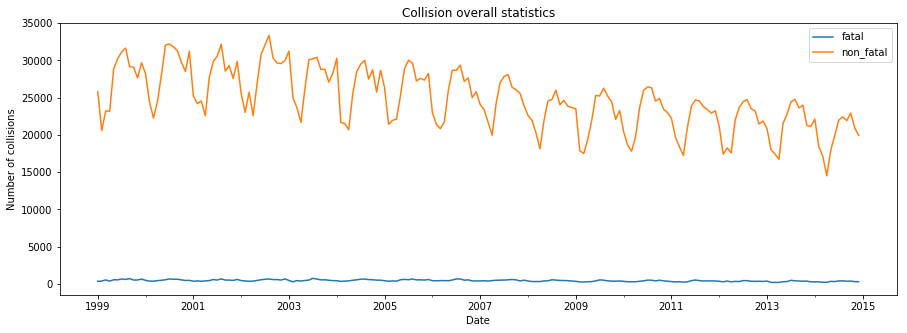

In [10]:
#The overall diagram
plot1=df_1.plot(figsize=(15,5),title='Collision overall statistics')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions")

Text(0,0.5,'Number of collisions')

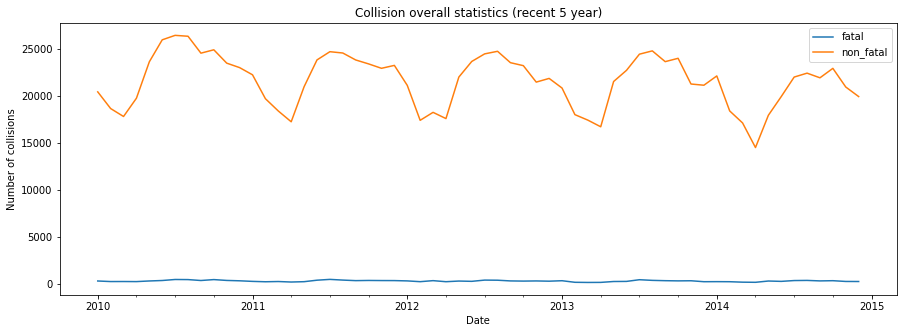

In [11]:
# Since the dateset period is 15 year, it's diffucult to identify a seasonality pattern in this scale
# Thus, a smaller period was selected to identify on-peak and off-peak of collisions
plot1=df_1[-60:].plot(figsize=(15,5),title='Collision overall statistics (recent 5 year)')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions")

Text(0,0.5,'Number of collisions')

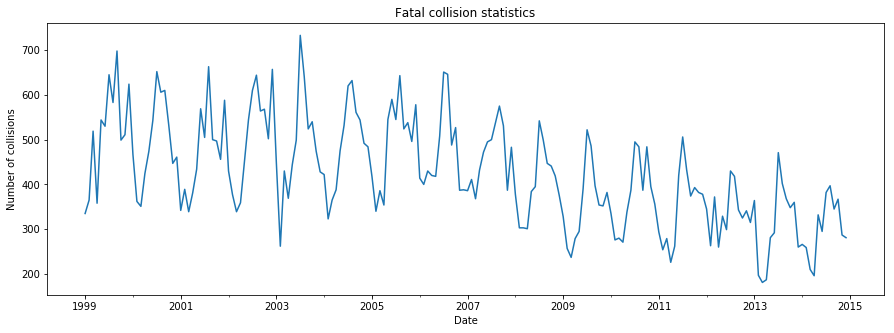

In [12]:
# Due to a huge difference in number of fatal and non-fatal collisions, fatal collisions trend was analyzed in its own scale.
# Overall statistics
plot2=df_1['fatal'].plot(figsize=(15,5),title='Fatal collision statistics')
plot2.set_xlabel("Date")
plot2.set_ylabel("Number of collisions")

Text(0,0.5,'Number of collisions')

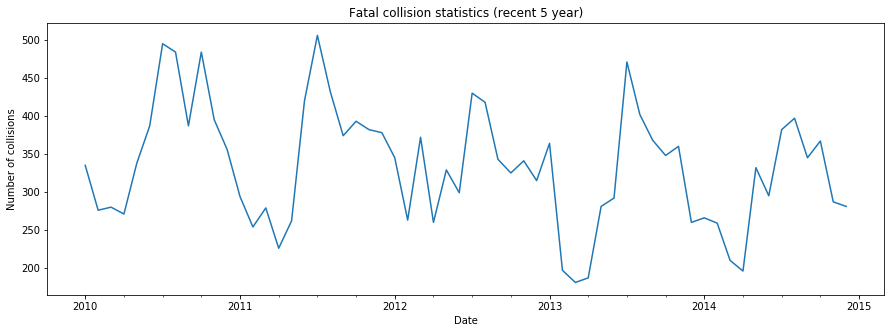

In [13]:
# Fatal collision statistics for the recent 5 years
plot1=df_1['fatal'][-60:].plot(figsize=(15,5),title='Fatal collision statistics (recent 5 year)')
plot1.set_xlabel("Date")
plot1.set_ylabel("Number of collisions")

##### Conslusion: The  collision trend declines slightly over years and has pronounced seasonality pattern. The collision peak is in the middle of year and downturn is in Q1.

#### (2) Correlation between total number of collisions and fatal collisions
##### Autocorrelation plot demostrates an obvious seasonality with period of 12 months.

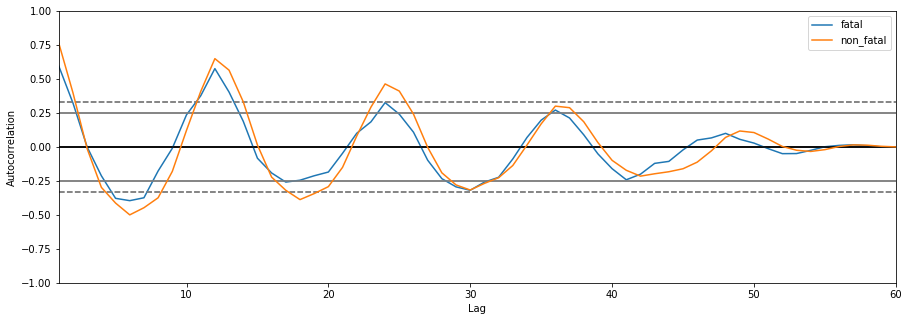

In [14]:
# To confirm the seasonality assumtion, the autocorrelation of fatal and non-fatal collisions was performed for 
# the recent 5 years.
plt.figure(figsize=(15,5))
for c in df_1.columns:
    autocorrelation_plot(df_1[c][-60:],label=c)

##### The fatal and non-fatal collisions have strong positive correlation.

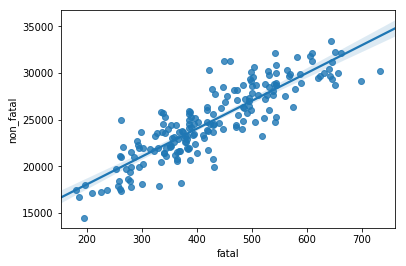

In [15]:
sns.regplot('fatal', 'non_fatal', data=df_1)

#### The  correlation coefficient between fatal and non fatal collisions is 0.87

In [16]:
corr = df_1.corr()
corr

,fatal,non_fatal
fatal,1.000000,0.870378
non_fatal,0.870378,1.000000


#### 3.Analysis of collision risk dependency on different week day and day hours

In [17]:
# Collisions by weekday
by_weekday = df.groupby('c_wday')['c_sev'].count()
by_weekday


c_wday
1    639638
2    675208
3    681798
4    718605
5    827059
6    717424
7    583590
Name: c_sev, dtype: int64

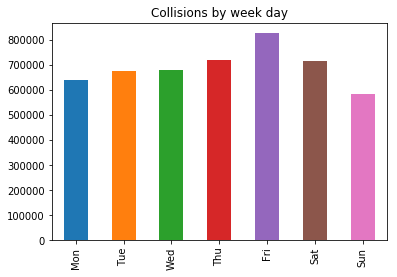

In [18]:
by_weekday = df.groupby('c_wday')['c_sev'].count()
by_weekday.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plot2 = by_weekday.plot(kind='bar',title='Collisions by week day')

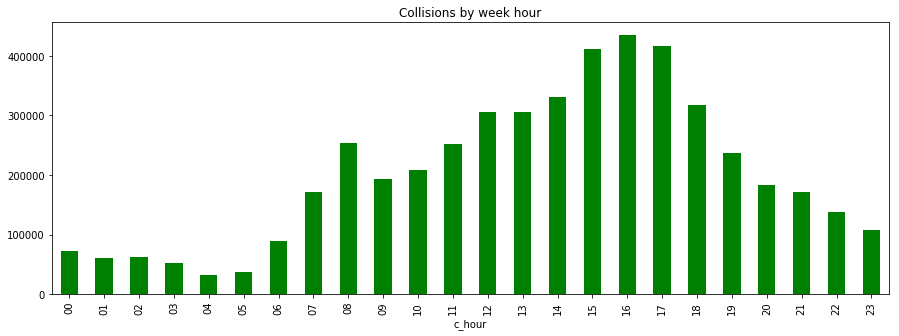

In [19]:
# Collisions by hour
plt.figure(figsize=(15,5))
by_hour = df.groupby('c_hour')['c_sev'].count()
plot3 = by_hour.plot(kind='bar',title='Collisions by week hour',color='G')

##### Conclusion: The higher collision risk is on Friday and the lowest is on Sunday.
##### The riskiest period is from 3 pm to 5 pm. Night hours have the lowest collision risk.

#### 4.Analysis of the following factors to collision rate:
####    a) Road configuration
####    b) Weather
####    c) Road surface
####    d) Traffic control

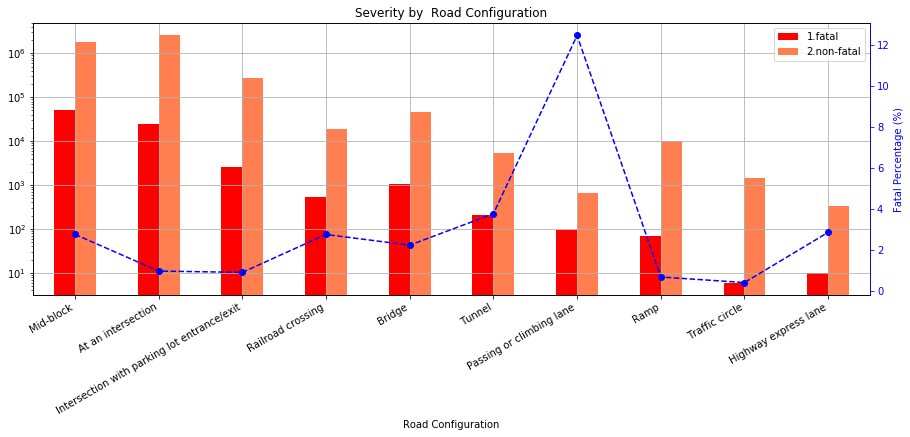

In [25]:
#Collisions severity by road configuration (c_rcfg field)
rcfg_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane','Ramp','Traffic circle',
            'Highway express lane','Highway collector lane','Highway transfer lane']

df_2 = df.groupby(['c_rcfg','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df_2.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by  Road Configuration', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(rcfg_type,ha='right')
ax1.set_xlabel('Road Configuration')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df_2[1]/(df_2[1]+df_2[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,10),rcfg_type); 

#### Conclusion:
It was noticed that majority of collisions occur at mid-block and intersection, the fatality rate is very high in collisions with passing or climbing lane ~12%.

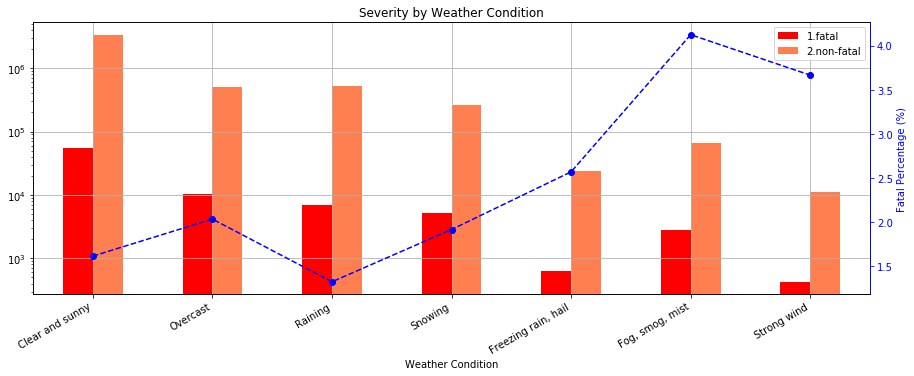

In [27]:
#Collisions severity  by Weather Condition  (c_wthr field)
wthr_type = ['Clear and sunny','Overcast','Raining','Snowing','Freezing rain, hail','Fog, smog, mist',
            'Strong wind']

df_3 = df.groupby(['c_wthr','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df_3.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Weather Condition', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(wthr_type,ha='right')
ax1.set_xlabel('Weather Condition')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df_3[1]/(df_3[1]+df_3[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,7),wthr_type); 

#### Conclusion:
It was noticed that majority of collisions occur on clean and sunny day. Howeverm a fatal collision rate is higher when visibility is limited (fog, mist) and when tehre is a strong wing. The fatality rate when last two conditions is about 4%.

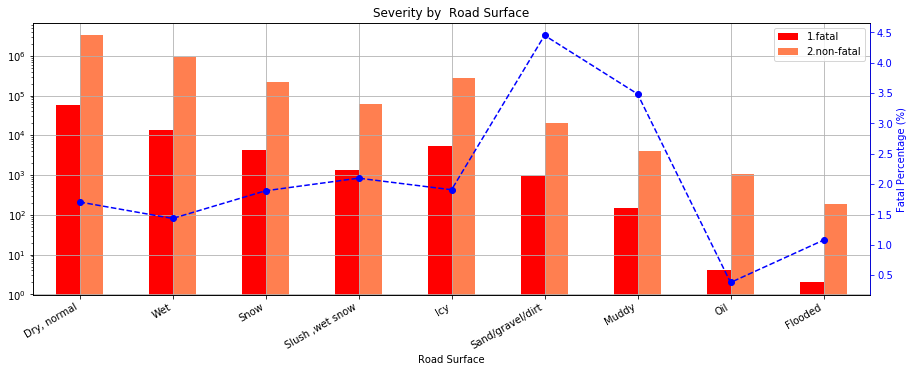

In [29]:
#Collision severity grouped by Road Surface (c_rsur field)
rsur_type = ['Dry, normal','Wet','Snow','Slush ,wet snow','Icy','Sand/gravel/dirt','Muddy','Oil','Flooded']

df_4 = df.groupby(['c_rsur','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df_4.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by  Road Surface', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(rsur_type,ha='right')
ax1.set_xlabel('Road Surface')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df_4[1]/(df_4[1]+df_4[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,9),rsur_type); 

#### Conclusion:
While the most of collisions occur on dry and normal road, the fatal collision rate is higher on sandy, dirty and muddy road. The fatality rate is up to 4.5%.

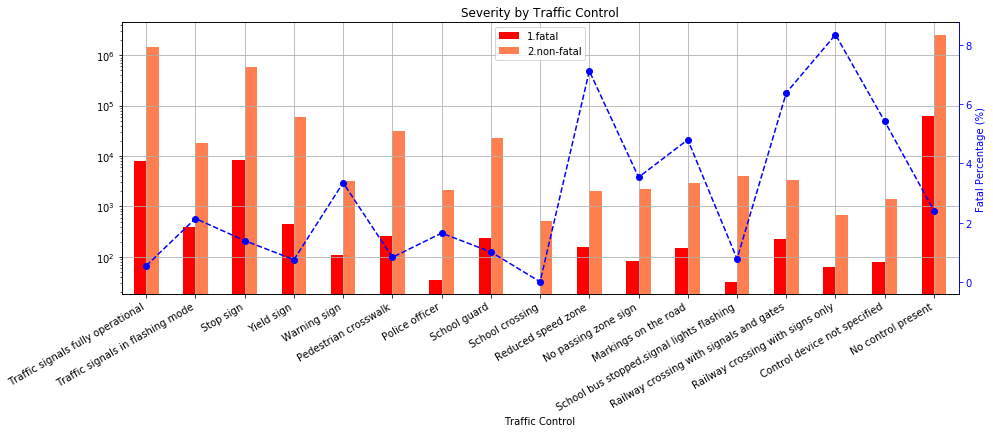

In [24]:
#Collisions severity  by Traffic Control (c_traf field)
traf_type = ['Traffic signals fully operational','Traffic signals in flashing mode','Stop sign','Yield sign','Warning sign',
            'Pedestrian crosswalk','Police officer','School guard','School crossing','Reduced speed zone',
            'No passing zone sign','Markings on the road','School bus stopped,signal lights flashing',
            'Railway crossing with signals and gates',
             'Railway crossing with signs only','Control device not specified','No control present']

df_4 = df.groupby(['c_traf','c_sev']).size().unstack().fillna(0)
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.set_ylabel('Fatal Percentage (%)')
ax2.spines['right'].set_color('b')
ax2.yaxis.label.set_color('b')
ax2.tick_params(axis='y',colors='b')

#Plot the new dataframe in logarithm, since the gap between numbers are huge.

df_4.plot(kind='bar',rot=30,logy=True,color=['red','coral'],figsize=(15,5),
         title='Severity by Traffic Control', ax=ax1)
ax1.grid(axis='both')
ax1.legend(['1.fatal','2.non-fatal'])
ax1.set_xticklabels(traf_type,ha='right')
ax1.set_xlabel('Traffic Control')

#Calculate the percentage of fatal injury in all accidents by different road surface type,
# and plot to right axis.
se1 = df_4[1]/(df_4[1]+df_4[2])*100
se1.plot(c='b', style='o--', ax=ax2)

plt.xticks(np.arange(0,17),traf_type); 

#### Conclusion:
The majority of collucions happened when traffic signals were fully operational and when no tracffic control present.
The highest fatality rate is reported for collisions occered on railway crossing which is quite logical. Surprisingly, the fatality rate in reduced speed zone was very close to fatality rate for collisions near railway sign and reached 7%.